In [30]:
%load_ext line_profiler

(2, 256, 256, 256)


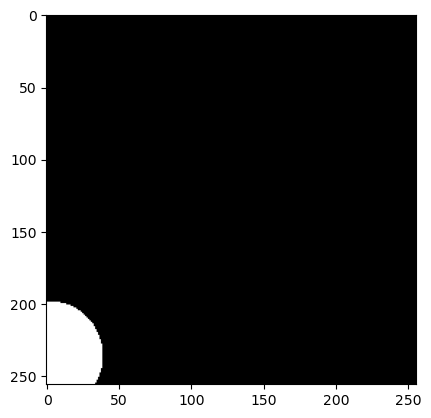

In [32]:
#@title 3D Phantom Definition

# Voxelised 3D medical imaging phantom (comprising of random shapes) in numpy ndarray format

import numpy as np

phan_size: int = 256
channels: int = 2 # Channel 0: Scattering Coefficient, Channel 1: Attenuation Coefficient
chan_scat_coef: int = 0
chan_atten_coef: int = 1

def create_random_voxel_phantom(shape=(channels, phan_size, phan_size, phan_size), num_shapes=3):
    """
    Creates a voxelized 3D medical imaging phantom with random shapes. (Values in range 0 to 1f)

    Args:
      shape: The shape of the 3D array (c, x, y, z).
      num_shapes: The number of random shapes to generate.

    Returns:
      A NumPy ndarray representing the 3D phantom.
    """

    phantom = np.zeros(shape, dtype=np.float32)

    for _ in range(num_shapes):
      # Randomly determine the shape of each object
      shape_type = np.random.choice(["sphere", "cube", "ellipsoid"])

      # Randomly select coordinates and dimensions for the shape
      center_x = np.random.randint(0, shape[-3])
      center_y = np.random.randint(0, shape[-2])
      center_z = np.random.randint(0, shape[-1])
      radius = np.random.randint(min(shape[-3:]) // 5, min(shape[-3:]) // 3) # Adjust radius based on phantom size

      # Generate voxel indices for the shape
      x_indices = np.arange(shape[-3])
      y_indices = np.arange(shape[-2])
      z_indices = np.arange(shape[-1])
      x, y, z = np.meshgrid(x_indices, y_indices, z_indices)

      if shape_type == "sphere":
        # Draw a sphere
        voxel_indices = (x - center_x)**2 + (y - center_y)**2 + (z - center_z)**2 <= radius**2
      elif shape_type == "cube":
        # Draw a cube
        voxel_indices = np.logical_and(np.abs(x - center_x) <= radius,
                                        np.logical_and(np.abs(y - center_y) <= radius,
                                                        np.abs(z - center_z) <= radius))

      elif shape_type == "ellipsoid":
          # Draw an ellipsoid with different radii along each axis
          a = radius  # x-axis radius
          b = radius * np.random.uniform(0.7, 1.3) # y-axis radius
          c = radius * np.random.uniform(0.7, 1.3) # z-axis radius
          voxel_indices = ((x - center_x)**2 / a**2) + ((y - center_y)**2 / b**2) + ((z - center_z)**2 / c**2) <= 1
      else:
        continue

      # Update the phantom
      phantom[chan_scat_coef][voxel_indices] = np.random.random()  # Assign random grayscale value
      phantom[chan_atten_coef][voxel_indices] = np.random.random()  # Assign random grayscale value for other channel

    return phantom

# Generate and display a phantom
phantom = create_random_voxel_phantom()
print(phantom.shape)
# You can now visualize or further process phantom
# Using matplotlib for visualization
import matplotlib.pyplot as plt
plt.imshow(phantom[chan_scat_coef,0,:,:], cmap="gray")
plt.show()



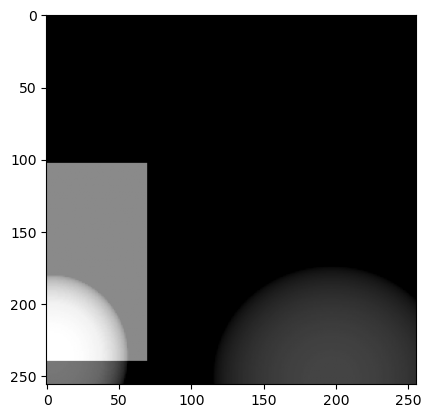

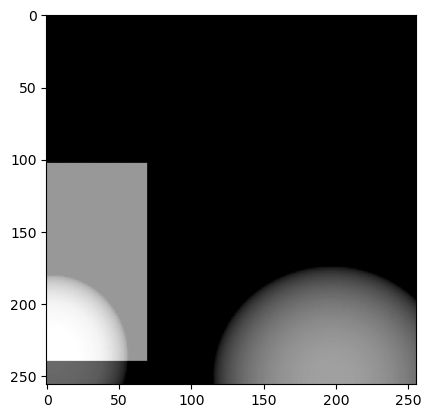

In [33]:
plt.imshow(np.sum(phantom, -3)[chan_scat_coef], cmap="gray")
plt.show()

plt.imshow(np.sum(phantom, -3)[chan_atten_coef], cmap="gray")
plt.show()

In [5]:
#@title Siddon Path Tracing 3D

import math
import sys

def siddon_3d(p1: tuple, p2: tuple, phan_size: int) -> tuple[list, list]:
  # TODO: hmm, possible division by zero if one of our axes doesn't change from p1 to p2 (when calc. alpha)
  # ^^^ FIX: added epsilon
  # TODO: also... at the end, m doesn't cover all indices (as we'd go out of range otherwise)

  planes = phan_size + 1

  voxels_to_traverse: list[tuple] = []
  voxels_to_traverse_path_lens: list[float] = []

  # The corner of the pixel space where the axes intersect
  b_x = 0
  b_y = 0
  b_z = 0

  # Distance between planes
  d_x = 1
  d_y = 1
  d_z = 1

  def alpha_x(i: int) -> float:
    numerator = (b_x + i * d_x) - p1[0]
    denominator = p2[0] - p1[0] + sys.float_info.epsilon
    return numerator / denominator

  def alpha_y(j: int) -> float:
    numerator = (b_y + j * d_y) - p1[1]
    denominator = p2[1] - p1[1] + sys.float_info.epsilon
    return numerator / denominator

  def alpha_z(k: int) -> float:
    numerator = (b_z + k * d_z) - p1[2]
    denominator = p2[2] - p1[2] + sys.float_info.epsilon
    return numerator / denominator

  alpha_x_min = min(alpha_x(0), alpha_x(planes-1))
  alpha_x_max = max(alpha_x(0), alpha_x(planes-1))
  alpha_y_min = min(alpha_y(0), alpha_y(planes-1))
  alpha_y_max = max(alpha_y(0), alpha_y(planes-1))
  alpha_z_min = min(alpha_z(0), alpha_z(planes-1))
  alpha_z_max = max(alpha_z(0), alpha_z(planes-1))

  alpha_min = max(0, alpha_x_min, alpha_y_min, alpha_z_min)
  alpha_max = min(1, alpha_x_max, alpha_y_max, alpha_z_max)

  def p_x(alpha: float) -> float:
    return p1[0] + alpha * (p2[0] - p1[0])

  def p_y(alpha: float) -> float:
    return p1[1] + alpha * (p2[1] - p1[1])

  def p_z(alpha: float) -> float:
    return p1[2] + alpha * (p2[2] - p1[2])

  def phi_x(alpha: float) -> float:
    numerator = p_x(alpha) - b_x
    denominator = d_x
    return numerator / denominator

  def phi_y(alpha: float) -> float:
    numerator = p_y(alpha) - b_y
    denominator = d_y
    return numerator / denominator

  def phi_z(alpha: float) -> float:
    numerator = p_z(alpha) - b_z
    denominator = d_z
    return numerator / denominator

  # Determine i_min and i_max, j_min and j_max, k_min and k_max

  i_min: int | None = None
  i_max: int | None = None
  j_min: int | None = None
  j_max: int | None = None
  k_min: int | None = None
  k_max: int | None = None

  if p1[0] < p2[0]:
    i_min = 1 if alpha_min == alpha_x_min else math.ceil(phi_x(alpha_min))
    i_max = planes - 1 if alpha_max == alpha_x_max else math.floor(phi_x(alpha_max))
  else:
    i_max = planes - 2 if alpha_min == alpha_x_min else math.floor(phi_x(alpha_min))
    i_min = 0 if alpha_max == alpha_x_max else math.ceil(phi_x(alpha_max))

  if p1[1] < p2[1]:
    j_min = 1 if alpha_min == alpha_y_min else math.ceil(phi_y(alpha_min))
    j_max = planes - 1 if alpha_max == alpha_y_max else math.floor(phi_y(alpha_max))
  else:
    j_max = planes - 2 if alpha_min == alpha_y_min else math.floor(phi_y(alpha_min))
    j_min = 0 if alpha_max == alpha_y_max else math.ceil(phi_y(alpha_max))

  if p1[2] < p2[2]:
    k_min = 1 if alpha_min == alpha_z_min else math.ceil(phi_z(alpha_min))
    k_max = planes - 1 if alpha_max == alpha_z_max else math.floor(phi_z(alpha_max))
  else:
    k_max = planes - 2 if alpha_min == alpha_z_min else math.floor(phi_z(alpha_min))
    k_min = 0 if alpha_max == alpha_z_max else math.ceil(phi_z(alpha_max))

  # print(i_min, i_max, j_min, j_max, k_min, k_max)

  # Calc arrays alpha_x[] alpha_y[] alpha_z[] which hold parametric vals for intersection points of the
  # ray with the x- respect to y-planes, after the ray has entered pixel space.

  alpha_x_arr: list[float] = []
  alpha_y_arr: list[float] = []
  alpha_z_arr: list[float] = []

  # TODO: does the if/else really do anything?
  if p1[0] < p2[0]:
    alpha_x_arr = [alpha_x(i) for i in range(i_min, i_max+1, 1)]
  else:
    alpha_x_arr = [alpha_x(i) for i in range(i_max, i_min-1, -1)]

  if p1[1] < p2[1]:
    alpha_y_arr = [alpha_y(j) for j in range(j_min, j_max+1, 1)]
  else:
    alpha_y_arr = [alpha_y(j) for j in range(j_max, j_min-1, -1)]

  if p1[2] < p2[2]:
    alpha_z_arr = [alpha_z(k) for k in range(k_min, k_max+1, 1)]
  else:
    alpha_z_arr = [alpha_z(k) for k in range(k_max, k_min-1, -1)]

  # Combine alpha_min, alpha_ x,y,z _arr's together and sort acendingly
  alpha_xyz_arr: list[float] = [alpha_min] + alpha_x_arr + alpha_y_arr + alpha_z_arr + [alpha_max]
  # Remove duplicates
  alpha_xyz_arr = list(set(alpha_xyz_arr))
  alpha_xyz_arr.sort()

  # To calculate coordinates of intersected pixels
  def i(m: int) -> int:
    numerator = alpha_xyz_arr[m] + alpha_xyz_arr[m-1]
    denominator = 2
    return math.floor(phi_x(numerator / denominator))

  def j(m: int) -> int:
    numerator = alpha_xyz_arr[m] + alpha_xyz_arr[m-1]
    denominator = 2
    return math.floor(phi_y(numerator / denominator))

  def k(m: int) -> int:
    numerator = alpha_xyz_arr[m] + alpha_xyz_arr[m-1]
    denominator = 2
    return math.floor(phi_z(numerator / denominator))

  p1p2euclidDist = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)
  def length(m: int) -> float:
    return (alpha_xyz_arr[m] - alpha_xyz_arr[m-1]) * p1p2euclidDist

  for m in range(1, len(alpha_xyz_arr)):
    voxels_to_traverse.append((i(m), j(m), k(m)))
    voxels_to_traverse_path_lens.append(length(m))

  # print(voxels_to_traverse)
  # print(voxels_to_traverse_path_lens)

  return voxels_to_traverse, voxels_to_traverse_path_lens



[(20, 20, 0), (21, 21, 0), (22, 22, 0), (23, 23, 0), (24, 24, 0), (25, 25, 0), (26, 26, 0), (27, 27, 0), (28, 28, 0), (29, 29, 0), (30, 30, 0), (31, 31, 0), (32, 32, 0), (33, 33, 0), (34, 34, 0), (35, 35, 0), (36, 36, 0), (37, 37, 0), (38, 38, 0), (39, 39, 0), (40, 40, 0), (41, 41, 0), (42, 42, 0), (43, 43, 0), (44, 44, 0), (56294995342131232, 56294995342131232, 0), (168884986026393632, 168884986026393632, 0), (281474976710656032, 281474976710656032, 0), (394064967394918400, 394064967394918400, 0), (506654958079180800, 506654958079180800, 0), (619244948763443200, 619244948763443200, 0), (731834939447705600, 731834939447705600, 0), (844424930131968000, 844424930131968000, 0), (957014920816230400, 957014920816230400, 0), (1069604911500492800, 1069604911500492800, 0), (1182194902184755200, 1182194902184755200, 0), (1294784892869017600, 1294784892869017600, 0), (1407374883553280000, 1407374883553280000, 0), (1519964874237542400, 1519964874237542400, 0), (1632554864921804800, 16325548649218

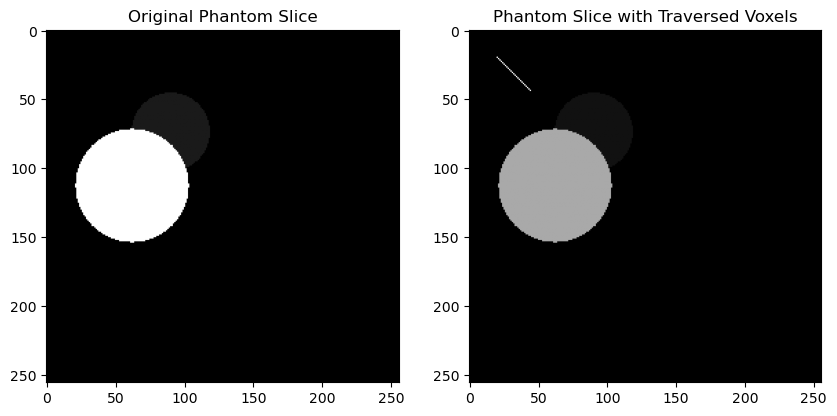

In [6]:
#@title Testing Siddon 3D

# Use the siddon_3d function defined above, with 2 random points, and visualise the traversed pixels in an ndarray plot

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'phantom' and 'siddon_3d' are defined as in the provided code.

# Generate two random 3D points within the phantom's boundaries.
phantom_shape = phantom.shape
p1 = (20, 20, 0)
p2 = (45, 45, 0)

# Call the siddon_3d function.
voxels_traversed, path_lengths = siddon_3d(p1, p2, phan_size)
print(voxels_traversed)
print(path_lengths)

# Create a copy of the phantom to visualize traversed voxels.
phantom_visualization = np.copy(phantom)

# Mark the traversed voxels.
for voxel in voxels_traversed:
  if 0 <= voxel[0] < phantom_shape[-3] and 0 <= voxel[1] < phantom_shape[-2] and 0 <= voxel[2] < phantom_shape[-1]:
    phantom_visualization[chan_scat_coef][voxel] = 1.0  # Or any other distinct value.
    phantom_visualization[chan_atten_coef][voxel] = 1.0  # Or any other distinct value.

# Display a slice of the phantom with the traversed voxels highlighted.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(phantom[chan_scat_coef, :, :, 0], cmap="gray")
plt.title("Original Phantom Slice")
plt.subplot(1, 2, 2)
plt.imshow(phantom_visualization[chan_scat_coef, :, :, 0], cmap="gray")
plt.title("Phantom Slice with Traversed Voxels")
plt.show()


In [7]:
#@title Siddon Jacobs 3D (In progress)

import math
import sys

def siddon_jacobs_3d(p1: tuple, p2: tuple, phan_size: int) -> tuple[list, list]:
  planes = phan_size + 1
  # EDGE CASE: point 1 is 1 or 2 pixels from the edge of the phantom

  d_12: float = 0 # Line integral of the attenuation coefficient
  voxels_to_traverse: list[tuple] = []
  voxels_to_traverse_path_lens: list[float] = []

  # The corner of the pixel space where the axes intersect
  b_x = 0
  b_y = 0
  b_z = 0

  # Distance between planes
  d_x = 1
  d_y = 1
  d_z = 1

  def calc_alpha_x(i: int) -> float:
    numerator = (b_x + i * d_x) - p1[0]
    denominator = p2[0] - p1[0] + sys.float_info.epsilon
    return numerator / denominator

  def calc_alpha_y(j: int) -> float:
    numerator = (b_y + j * d_y) - p1[1]
    denominator = p2[1] - p1[1] + sys.float_info.epsilon
    return numerator / denominator

  def calc_alpha_z(k: int) -> float:
    numerator = (b_z + k * d_z) - p1[2]
    denominator = p2[2] - p1[2] + sys.float_info.epsilon
    return numerator / denominator

  alpha_x_min = min(calc_alpha_x(0), calc_alpha_x(planes-1))
  alpha_x_max = max(calc_alpha_x(0), calc_alpha_x(planes-1))
  alpha_y_min = min(calc_alpha_y(0), calc_alpha_y(planes-1))
  alpha_y_max = max(calc_alpha_y(0), calc_alpha_y(planes-1))
  alpha_z_min = min(calc_alpha_z(0), calc_alpha_z(planes-1))
  alpha_z_max = max(calc_alpha_z(0), calc_alpha_z(planes-1))

  alpha_min = max(0, alpha_x_min, alpha_y_min, alpha_z_min)
  alpha_max = min(1, alpha_x_max, alpha_y_max, alpha_z_max)

  def p_x(alpha: float) -> float:
    return p1[0] + alpha * (p2[0] - p1[0])

  def p_y(alpha: float) -> float:
    return p1[1] + alpha * (p2[1] - p1[1])

  def p_z(alpha: float) -> float:
    return p1[2] + alpha * (p2[2] - p1[2])

  def phi_x(alpha: float) -> float:
    numerator = p_x(alpha) - b_x
    denominator = d_x
    return numerator / denominator

  def phi_y(alpha: float) -> float:
    numerator = p_y(alpha) - b_y
    denominator = d_y
    return numerator / denominator

  def phi_z(alpha: float) -> float:
    numerator = p_z(alpha) - b_z
    denominator = d_z
    return numerator / denominator

  # Determine i_min and i_max, j_min and j_max, k_min and k_max

  i_min: int | None = None
  i_max: int | None = None
  j_min: int | None = None
  j_max: int | None = None
  k_min: int | None = None
  k_max: int | None = None

  if p1[0] < p2[0]:
    i_min = 1 if alpha_min == alpha_x_min else math.ceil(phi_x(alpha_min))
    i_max = planes - 1 if alpha_max == alpha_x_max else math.floor(phi_x(alpha_max))
  else:
    i_max = planes - 2 if alpha_min == alpha_x_min else math.floor(phi_x(alpha_min))
    i_min = 0 if alpha_max == alpha_x_max else math.ceil(phi_x(alpha_max))

  if p1[1] < p2[1]:
    j_min = 1 if alpha_min == alpha_y_min else math.ceil(phi_y(alpha_min))
    j_max = planes - 1 if alpha_max == alpha_y_max else math.floor(phi_y(alpha_max))
  else:
    j_max = planes - 2 if alpha_min == alpha_y_min else math.floor(phi_y(alpha_min))
    j_min = 0 if alpha_max == alpha_y_max else math.ceil(phi_y(alpha_max))

  if p1[2] < p2[2]:
    k_min = 1 if alpha_min == alpha_z_min else math.ceil(phi_z(alpha_min))
    k_max = planes - 1 if alpha_max == alpha_z_max else math.floor(phi_z(alpha_max))
  else:
    k_max = planes - 2 if alpha_min == alpha_z_min else math.floor(phi_z(alpha_min))
    k_min = 0 if alpha_max == alpha_z_max else math.ceil(phi_z(alpha_max))

  # print(i_min, i_max, j_min, j_max, k_min, k_max)

  alpha_x: float | None = None
  alpha_y: float | None = None
  alpha_z: float | None = None

  if p1[0] < p2[0]:
    alpha_x = calc_alpha_x(i_min)
  elif p1[0] == p2[0]:
    alpha_x = alpha_x_max
  else:
    alpha_x = calc_alpha_x(i_max)

  if p1[1] < p2[1]:
    alpha_y = calc_alpha_y(j_min)
  elif p1[1] == p2[1]:
    alpha_y = alpha_y_max
  else:
    alpha_y = calc_alpha_y(j_max)

  if p1[2] < p2[2]:
    alpha_z = calc_alpha_z(k_min)
  elif p1[2] == p2[2]:
    alpha_z = alpha_z_max
  else:
    alpha_z = calc_alpha_z(k_max)
  
  i: int | None = None
  if True:
    numerator = min(alpha_x, alpha_y, alpha_z) + alpha_min
    denominator = 2
    i = math.floor(phi_x(numerator / denominator))
  if True:
    numerator = min(alpha_x, alpha_y, alpha_z) + alpha_min
    denominator = 2
    j = math.floor(phi_y(numerator / denominator))
  if True:
    numerator = min(alpha_x, alpha_y, alpha_z) + alpha_min
    denominator = 2
    k = math.floor(phi_z(numerator / denominator))

  # Update alpha_x, alpha_y, alpha_z and i j k
  # Accoding to whether we cross an x, y or z plane

  a_xu = d_x / (abs(p2[0] - p1[0]) + sys.float_info.epsilon)
  a_yu = d_y / (abs(p2[1] - p1[1]) + sys.float_info.epsilon)
  a_zu = d_z / (abs(p2[2] - p1[2]) + sys.float_info.epsilon)

  i_u: int = 1 if p1[0] < p2[0] else -1
  j_u: int = 1 if p1[1] < p2[1] else -1
  k_u: int = 1 if p1[2] < p2[2] else -1

  alpha_c = alpha_min
  d_conv = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

  while alpha_c < alpha_max:

    i_to_add: int = i
    j_to_add: int = j
    k_to_add: int = k

    length: float = 0

    if (alpha_x <= alpha_y) and (alpha_x <= alpha_z):
      length = (alpha_x - alpha_c) * d_conv

      alpha_c = alpha_x
      alpha_x = alpha_x + a_xu
      
      i = i + i_u

    elif (alpha_y <= alpha_x) and (alpha_y <= alpha_z):
      length = (alpha_y - alpha_c) * d_conv

      alpha_c = alpha_y
      alpha_y = alpha_y + a_yu

      j = j + j_u
      
    else: # alpha_z is smallest
      length = (alpha_z - alpha_c) * d_conv

      alpha_c = alpha_z
      alpha_z = alpha_z + a_zu
      k = k + k_u

    if alpha_c > alpha_max:
      break
    
    if length > 0:
      voxels_to_traverse.append((i_to_add, j_to_add, k_to_add))
      voxels_to_traverse_path_lens.append(length)

  return voxels_to_traverse, voxels_to_traverse_path_lens



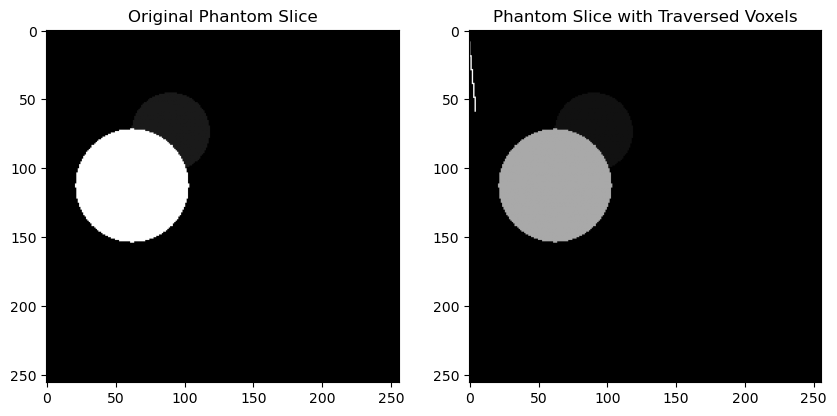

In [8]:
#@title Testing Siddon Jacobs 3D

# Use the siddon_jacobs_3d function defined above, with 2 random points, and visualise the traversed pixels in an ndarray plot

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'phantom' and 'siddon_3d' are defined as in the provided code.

# Generate two random 3D points within the phantom's boundaries.
phantom_shape = phantom.shape
p1 = (-1, -1, 1)
p2 = (60, 5, 0)

# Call the siddon_3d function.
voxels_traversed, path_lengths = siddon_jacobs_3d(p1, p2, phan_size)

# Create a copy of the phantom to visualize traversed voxels.
phantom_visualization = np.copy(phantom)

# Mark the traversed voxels.
for voxel in voxels_traversed:
  if 0 <= voxel[0] < phantom_shape[-3] and 0 <= voxel[1] < phantom_shape[-2] and 0 <= voxel[2] < phantom_shape[-1]:
    phantom_visualization[chan_scat_coef][voxel] = 1.0  # Or any other distinct value.
    phantom_visualization[chan_atten_coef][voxel] = 1.0  # Or any other distinct value.

# Display a slice of the phantom with the traversed voxels highlighted.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(phantom[chan_scat_coef, :, :, 0], cmap="gray")
plt.title("Original Phantom Slice")
plt.subplot(1, 2, 2)
plt.imshow(phantom_visualization[chan_scat_coef, :, :, 0], cmap="gray")
plt.title("Phantom Slice with Traversed Voxels")
plt.show()


In [9]:
#@title Grid and Detector Response (Basic)

def grid_response() -> float:
  return 1

def detec_response() -> float:
  return 1

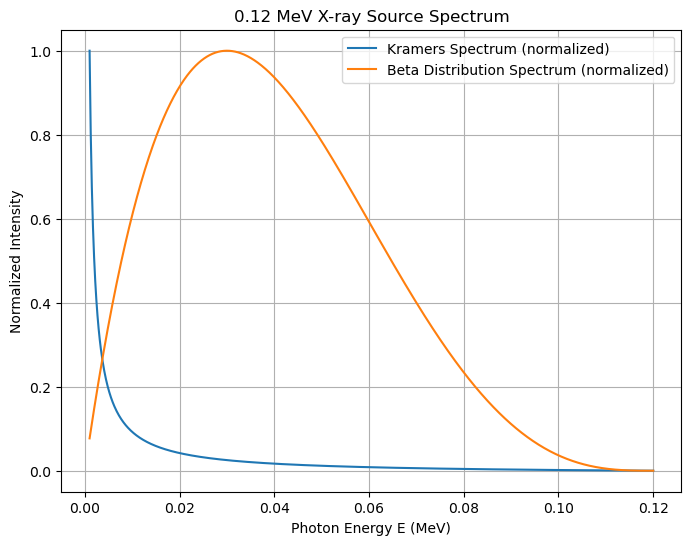

In [10]:
#@title X-Ray Source Spectra

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta as beta_func

# Maximum photon energy (E0) in MeV
E0 = 0.120

# --- Kramers Law Spectrum ---
def kramers_spectrum(E, E0=E0):
    """
    Kramers law: I(E) ∝ (E0 - E)/E for 0 < E < E0.
    For E=0, we define I=0 to avoid division by zero.
    """
    I = np.zeros_like(E)
    valid = (E > 0) & (E < E0)
    I[valid] = (E0 - E[valid]) / E[valid]
    return I

# --- Beta Distribution–Type Spectrum ---
def beta_spectrum(E, E0=E0, alpha=2.0, beta_param=2.0):
    """
    I(E) = I0 * (E/E0)^(alpha-1) * (1 - E/E0)^(beta_param-1)
    for 0 <= E <= E0. The function is normalized (I0 set so that
    the area under the curve equals 1) using the beta function.
    """
    x = E / E0
    I = np.zeros_like(E)
    valid = (E >= 0) & (E <= E0)
    I[valid] = x[valid]**(alpha-1) * (1 - x[valid])**(beta_param-1)
    # Normalize so that the integral over [0, E0] equals 1:
    norm = beta_func(alpha, beta_param) * E0
    return I / norm

# --- Define Energy Grid ---
# We avoid E=0 for Kramers law to prevent division by zero.
E = np.linspace(0.001, E0, 1000)

# Calculate spectra
I_kramers = kramers_spectrum(E, E0)
I_beta = beta_spectrum(E, E0, alpha=2.0, beta_param=4.0)

# Normalize for plotting (maximum value = 1)
I_kramers_norm = I_kramers / np.max(I_kramers)
I_beta_norm = I_beta / np.max(I_beta)

# --- Plotting ---
plt.figure(figsize=(8,6))
plt.plot(E, I_kramers_norm, label="Kramers Spectrum (normalized)")
plt.plot(E, I_beta_norm, label="Beta Distribution Spectrum (normalized)")
plt.xlabel("Photon Energy E (MeV)")
plt.ylabel("Normalized Intensity")
plt.title(f"{E0} MeV X-ray Source Spectrum")
plt.legend()
plt.grid(True)
plt.show()

Total cross section (σ_tot) = 2.561e-29 m²


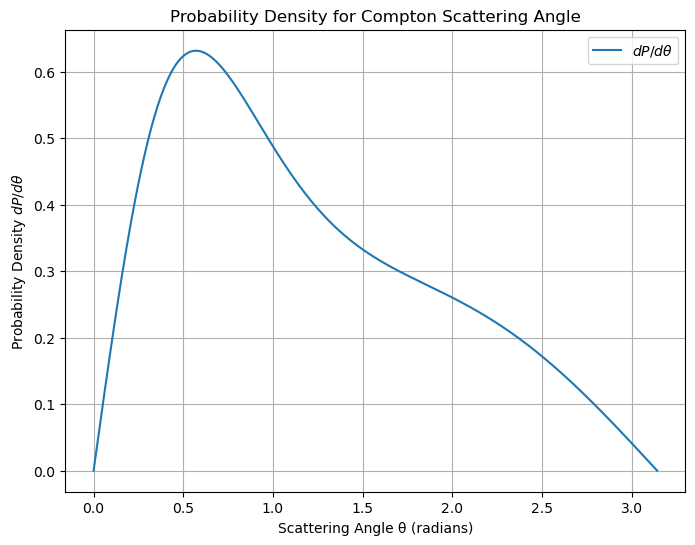

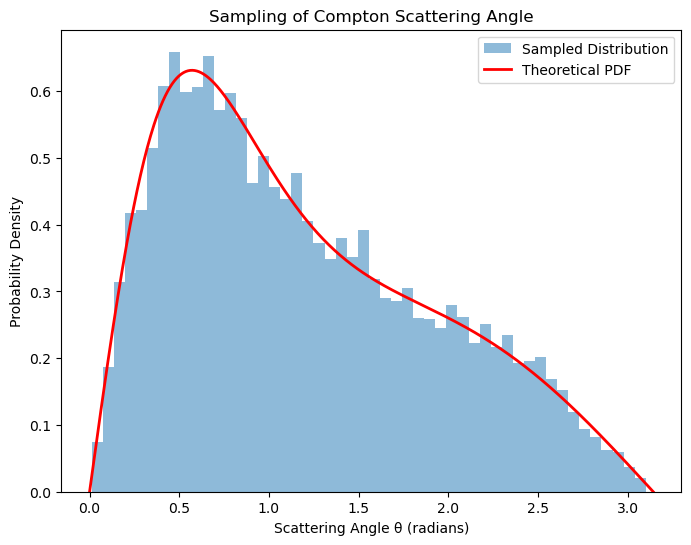

In [11]:
#@title Klein-Nishina Probability

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# ---------------------
# Constants
# ---------------------
r0 = 2.8179403227e-15  # Classical electron radius in meters
m_e_c2 = 0.511         # Electron rest energy in MeV

# ---------------------
# Functions
# ---------------------
def compton_energy(E, theta):
    """
    Compute the scattered photon energy E' given incident energy E (in MeV)
    and scattering angle theta (in radians) using the Compton formula.
    """
    return E / (1 + (E/m_e_c2) * (1 - np.cos(theta)))

def klein_nishina_dsigma_domega(theta, E):
    """
    Compute the Klein-Nishina differential cross section dσ/dΩ as a function of
    scattering angle theta (in radians) and incident energy E (in MeV).
    """
    E_prime = compton_energy(E, theta)
    factor = (E_prime/E)**2
    # Klein-Nishina formula
    return (r0**2 / 2) * factor * ((E/E_prime) + (E_prime/E) - np.sin(theta)**2)

# P.S. Scattering coefficient = Electron density * Total cross section
def total_cross_section(E):
    """
    Numerically integrate dσ/dΩ over all solid angles to obtain the total cross section σ_tot.
    Since the expression is independent of the azimuthal angle φ, the integration is:
Than
      σ_tot = 2π ∫₀^π sinθ dθ (dσ/dΩ)(θ, E)
    """
    integral, error = integrate.quad(lambda theta: np.sin(theta) * klein_nishina_dsigma_domega(theta, E), 0, np.pi)
    sigma_tot = 2 * np.pi * integral
    return sigma_tot

def probability_density(theta, E, sigma_tot):
    """
    Compute the probability density dP/dθ for scattering at angle theta.
    """
    return (2 * np.pi * np.sin(theta) * klein_nishina_dsigma_domega(theta, E)) / sigma_tot

# ---------------------
# Example: Compute and Plot PDF for a Given Energy
# ---------------------
test_E = 0.662  # Incident photon energy in MeV (e.g., from Cs-137 gamma ray)
sigma_tot = total_cross_section(test_E)
print(f"Total cross section (σ_tot) = {sigma_tot:.3e} m²")

# Create an array of theta values between 0 and π
thetas = np.linspace(0, np.pi, 500)
pdf = probability_density(thetas, test_E, sigma_tot)

plt.figure(figsize=(8,6))
plt.plot(thetas, pdf, label=r'$dP/d\theta$')
plt.xlabel('Scattering Angle θ (radians)')
plt.ylabel('Probability Density $dP/d\\theta$')
plt.title('Probability Density for Compton Scattering Angle')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------
# Rejection Sampling to Generate Scattering Angles
# ---------------------
def sample_theta(E, sigma_tot, n_samples=10000):
    """
    Sample scattering angles θ from the probability density function using rejection sampling.
    """
    theta_samples = []
    # Estimate the maximum value of the PDF (used for rejection sampling)
    theta_grid = np.linspace(0, np.pi, 500)
    p_vals = probability_density(theta_grid, E, sigma_tot)
    p_max = p_vals.max()

    while len(theta_samples) < n_samples:
        # Sample a candidate uniformly from [0, π]
        theta_candidate = np.random.uniform(0, np.pi)
        # Evaluate the PDF at this candidate
        p_candidate = probability_density(theta_candidate, E, sigma_tot)
        # Sample a uniform random number between 0 and p_max
        u = np.random.uniform(0, p_max)
        if u < p_candidate:
            theta_samples.append(theta_candidate)
    return np.array(theta_samples)

# Generate samples
n_samples = 10000
theta_samples = sample_theta(test_E, sigma_tot, n_samples=n_samples)

# Plot histogram of sampled angles against the theoretical PDF
plt.figure(figsize=(8,6))
plt.hist(theta_samples, bins=50, density=True, alpha=0.5, label='Sampled Distribution')
plt.plot(thetas, pdf, 'r-', lw=2, label='Theoretical PDF')
plt.xlabel('Scattering Angle θ (radians)')
plt.ylabel('Probability Density')
plt.title('Sampling of Compton Scattering Angle')
plt.legend()
plt.show()

In [38]:
#@title Full Generalised Radon Transform for One detector point

import numpy as np

E0 = 0.160 # Redefine here
voxel_physical_scale: float = 0.001 # 1 metre to 1mm thereabouts
theta: float = np.pi * (-2/6)
detec_size: int = phan_size
detec_dims: int = 2
detec_bins: int = 100
detec_max_e_mev: float = E0
detec_min_e_mev: float = 0.001
detec_dist_isocenter: int = detec_size * 0.5 * 3 # "Vaguely" around 50cm from iso
source_dist_isocenter: int = detec_size * 0.5 * 6 # "Vaguely" around 100cm from iso


def generalised_radon_transform(phantom: np.ndarray,
                                theta: float,
                                detec_point: tuple,
                                source_linspace: np.ndarray,
                                bin_linspace: np.ndarray) -> list[float]: # Energy bins for this pixel
  # Take line integral for our given theta and detec_point (coordinates on the detector grid, final axis is energy bin)

  e_intensities: dict[float, float] = {} # Key: Energy, Value: Accumulated intensity

  # Small nested function to check if a given coord is within the phantom bounds
  def is_within_bounds(coord: tuple) -> bool:
    return 0 <= coord[0] < phantom.shape[-3] and 0 <= coord[1] < phantom.shape[-2] and 0 <= coord[2] < phantom.shape[-1]

  # We'll rotate around the z axis
  detec_point_physical: np.ndarray = np.array([-detec_dist_isocenter, detec_point[0], detec_point[1]]) # left side
  source_point_physical: np.ndarray = np.array([0, source_dist_isocenter, 0]) # above

  # Translate both in the z axis by theta
  rot_mat: np.ndarray = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
  detec_point_physical = rot_mat @ detec_point_physical.T
  source_point_physical = rot_mat @ source_point_physical.T

  detec_point_physical_opposite = detec_point_physical * -1
  detec_point_physical_opposite[2] = detec_point_physical_opposite[2] * -1 # Keep rotation axis coord same

  # Make sure to translate these points back to phantom-space, with origin around midpoint of coords, not 0
  detec_point_physical = detec_point_physical + phan_size * 0.5
  detec_point_physical[2] = detec_point_physical[2] - phan_size * 0.5 # Keep rotation axis coord same
  source_point_physical = source_point_physical + phan_size * 0.5
  # source_point_physical[2] = source_point_physical[2] - phan_size * 0.5 # Keep rotation axis coord same
  detec_point_physical_opposite = detec_point_physical_opposite + phan_size * 0.5
  detec_point_physical_opposite[2] = detec_point_physical_opposite[2] - phan_size * 0.5 # Keep rotation axis coord same

  # Let's just turn our points into tuples for ease
  detec_point_physical = (detec_point_physical[0], detec_point_physical[1], detec_point_physical[2])
  source_point_physical = (source_point_physical[0], source_point_physical[1], source_point_physical[2])
  detec_point_physical_opposite = (detec_point_physical_opposite[0], detec_point_physical_opposite[1], detec_point_physical_opposite[2])

  # Get traversed pixels from detec_point_physical to detec_point_physical_opposite
  rd_r_voxels_all, rd_r_voxels_all_lens = siddon_jacobs_3d(detec_point_physical, detec_point_physical_opposite, phan_size)

  # Every voxel in this line is the result of a scatter incident, tracing back to the source.
  # So for each of these voxels (r's), also get the siddon result for r back to our source

  # Let's pre-compute our source beam beta spectrum
  source_spect = beta_spectrum(source_linspace, E0, alpha=2.0, beta_param=4.0)
  source_spect: dict[float, float] = dict(zip(source_linspace, source_spect))

  # We can save (very little) computation time by having a running tally of our rd_r attenuation integral
  # This is under the assumption that our iterations go from detector -> point r
  atten_rd_r_exp_running_integral: float = 0

  for _, (rd_r_voxel, rd_r_voxel_len) in enumerate(dict(zip(rd_r_voxels_all, rd_r_voxels_all_lens)).items()):

    if not is_within_bounds(rd_r_voxel):
      continue

    # Add to the rd_r attenuation tally before we keep looping over E's
    atten_rd_r_exp_running_integral = atten_rd_r_exp_running_integral + phantom[chan_atten_coef][rd_r_voxel] * rd_r_voxel_len * voxel_physical_scale

    # Grab our scattering coefficient now, and if no scattering can occur here,
    # we do not even need to consider propagating back up to r_rs
    r_scat_coef: float = phantom[chan_scat_coef][rd_r_voxel]
    if r_scat_coef == 0:
      continue

    # Get phi between this voxel and source
    r_rd_vec: tuple = (detec_point_physical[0] - rd_r_voxel[0], detec_point_physical[1] - rd_r_voxel[1], detec_point_physical[2] - rd_r_voxel[2])
    r_rs_vec: tuple = (source_point_physical[0] - rd_r_voxel[0], source_point_physical[1] - rd_r_voxel[1], source_point_physical[2] - rd_r_voxel[2])
    phi: float = np.pi - np.arccos(np.dot(r_rd_vec, r_rs_vec) / (np.linalg.norm(r_rd_vec) * np.linalg.norm(r_rs_vec)))

    # Get all the voxels between this voxel and the source
    r_rs_voxels, r_rs_voxels_lens = siddon_jacobs_3d(rd_r_voxel, source_point_physical, phan_size)

    atten_r_rs_exp_integral: float = 0
    for r_rs_voxel, r_rs_voxel_len in zip(r_rs_voxels, r_rs_voxels_lens):
      if not is_within_bounds(r_rs_voxel):
        continue
      atten_r_rs_exp_integral = atten_r_rs_exp_integral + phantom[chan_atten_coef][r_rs_voxel] * r_rs_voxel_len * voxel_physical_scale

    # We can now compute the inverse square laws for this voxel from source and detector
    # This is under the assumption that we have a cone-beam source - a hypothetical perfect parallel beam would not need this
    inv_sq_rd_r: float = 1 / (np.abs(np.linalg.norm(np.subtract(rd_r_voxel, detec_point_physical))) * voxel_physical_scale) # L2 norm is Euclid dist
    inv_sq_r_rs: float = 1 / (np.abs(np.linalg.norm(np.subtract(rd_r_voxel, source_point_physical))) * voxel_physical_scale) # L2 norm is Euclid dist

    # Let's cache computed Klein-Nishina values for each E', as many will be reused (when phi is fixed)
    klein_nishina_cache_Eprime_fixed_phi: dict[float, float] = {}

    # Let's integrate over all our desired energy bins
    for _, E in np.ndenumerate(bin_linspace):
      e_intensity: float | None = None
      
      # Placeholders
      grid_detec_response = grid_response() * detec_response()

      # Let's integrate over E' which will be from E up to E0, discretised
      # Nested loop: For each voxel from r to rs, see how the intensity lowers due to atten. + inverse sq. law.
      # These are all the energies that RESULT in our E, so sum up these intensities as they come
      eprimes_intensity_integral: float = 0
      for _, Eprime in np.ndenumerate(source_linspace):
        # A quick check here to see if our E' is greater than E
        if Eprime < E:
          continue

        eprime_intensity: float | None = None

        source_I_at_Eprime: float = source_spect[Eprime]
        scaled_I_r_rs: float = source_I_at_Eprime * inv_sq_r_rs

        # At the end of that voxel loop, we can then compute the Klein-Nishina prob that our scat originating from E' happens
        # and scale our tally accordingly
        klein_nishina_prob: float | None = None
        if Eprime in klein_nishina_cache_Eprime_fixed_phi:
          klein_nishina_prob = klein_nishina_cache_Eprime_fixed_phi[Eprime]
        else:
          klein_nishina_prob = klein_nishina_dsigma_domega(phi, Eprime)
          klein_nishina_cache_Eprime_fixed_phi[Eprime] = klein_nishina_prob

        eprime_intensity = scaled_I_r_rs * (np.e**(-atten_r_rs_exp_integral)) * klein_nishina_prob
        eprimes_intensity_integral = eprimes_intensity_integral + eprime_intensity

      # Now we can compute the final intensity from scatter point r from source all the way to detector, for this energy bin
      e_intensity = grid_detec_response * (np.e**(-atten_rd_r_exp_running_integral)) * inv_sq_rd_r * eprimes_intensity_integral
      # Don't forget to tag on our scattering coefficient!
      # Teeechnically this should be applied to the whole integral if our logic is for total energy integration
      # But for us, we are discretising bins
      e_intensity = e_intensity * r_scat_coef

      if E in e_intensities:
        e_intensities[E] = e_intensities[E] + e_intensity
      else:
        e_intensities[E] = e_intensity

  detec_point_output: list[float] = []
  for _, bin_E in np.ndenumerate(bin_linspace):
    detec_point_output.append(e_intensities[bin_E] if bin_E in e_intensities else 0)
  return detec_point_output

In [35]:
#@title Iterating Radon transform over detector point grid

from multiprocessing import Pool, cpu_count

debug: bool = True

def generalised_radon_transform_row(phantom: np.ndarray,
                                    theta: float,
                                    detec_row: int,
                                    source_linspace: np.ndarray,
                                    bin_linspace: np.ndarray) -> list[list[float]]:
  detec_row_output: list[list[float]] = []
  for detec_col in range(0, detec_size):
    detec_row_output.append(generalised_radon_transform(phantom, theta, (detec_row, detec_col), source_linspace, bin_linspace))
  return detec_row_output

def radon_over_detector_pixels(phantom: np.ndarray, detec_size: int, detec_dims: int, detec_bins: int) -> np.ndarray:
  detec_shape: list | tuple = []
  for i in range(0, detec_dims):
    detec_shape.append(detec_size)
  detec_shape.append(detec_bins) # Our bins are not included in the dims size, but we tag it on!
  detec_shape = tuple(detec_shape)
  detec_output: np.ndarray = np.zeros(detec_shape)

  source_linspace: np.ndarray = np.linspace(detec_min_e_mev, E0, detec_bins)
  bin_linspace: np.ndarray = np.linspace(detec_min_e_mev, detec_max_e_mev, detec_bins) # These two linspaces may well be the same

  if debug:
    print("DEBUG MODE: Running in serial mode")
    max_rows: int = 1
    for detec_row in range(0, max_rows):
      print(f"Processing row {detec_row}")
      detec_output[detec_row,:] = generalised_radon_transform_row(phantom, theta, detec_row, source_linspace, bin_linspace)
    return detec_output

  # Trying out multiprocessing
  cpus: int = cpu_count()
  with Pool(processes=cpus) as pool:
    print(f"Using {cpus} CPUs")

    reses: dict[tuple, np.ndarray] = {}

    for x in range(0, detec_size):
      res = pool.apply_async(generalised_radon_transform_row, args=(phantom,
                                                                    theta,
                                                                    x,
                                                                    source_linspace,
                                                                    bin_linspace
                                                                    ))
      reses[(x)] = res

    for x in range(0, detec_size):
      print(f"Processing row {x}")
      detec_output[x,:] = reses[(x)].get()

  return detec_output


Beginning the radon transform...
Using 20 CPUs
Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Processing row 8
Processing row 9
Processing row 10
Processing row 11
Processing row 12
Processing row 13
Processing row 14
Processing row 15
Processing row 16
Processing row 17
Processing row 18
Processing row 19
Processing row 20
Processing row 21
Processing row 22
Processing row 23
Processing row 24
Processing row 25
Processing row 26
Processing row 27
Processing row 28
Processing row 29
Processing row 30
Processing row 31
Processing row 32
Processing row 33
Processing row 34
Processing row 35
Processing row 36
Processing row 37
Processing row 38
Processing row 39
Processing row 40
Processing row 41
Processing row 42
Processing row 43
Processing row 44
Processing row 45
Processing row 46
Processing row 47
Processing row 48
Processing row 49
Processing row 50
Processing row 51
Processing row 52
Processin

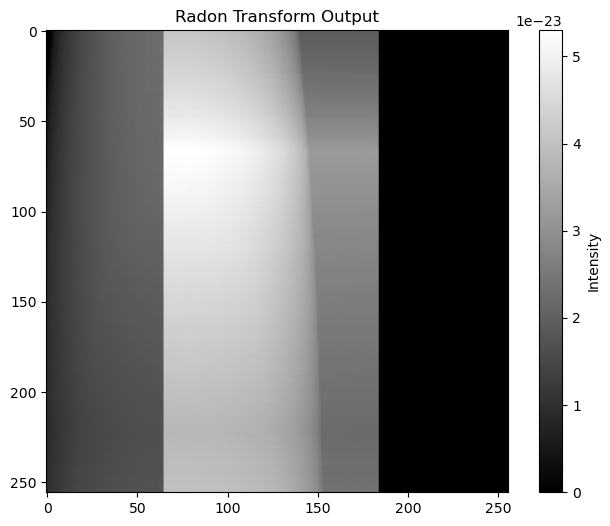

In [26]:
#@title Execution of Analytical model

# Use the radon_over_detector_pixels function over our phantom defined above

import matplotlib.pyplot as plt
# Assuming 'phantom', 'phan_size', 'chan_scat_coef', and 'chan_atten_coef' are defined from previous code

print("Beginning the radon transform...")

# Example usage:
radon_output = radon_over_detector_pixels(phantom, detec_size, detec_dims, detec_bins)

# Display the result (you'll likely want to visualize a slice of this 3D array)
# Example for a slice
plt.figure(figsize=(8, 6))
plt.imshow(np.sum(radon_output, axis=2), cmap="gray") # Visualising the sum over our energy bins (integrate energy)
plt.title("Radon Transform Output")
plt.colorbar(label="Intensity")
plt.show()


In [39]:
%lprun -f generalised_radon_transform radon_over_detector_pixels(phantom, detec_size, detec_dims, detec_bins)

DEBUG MODE: Running in serial mode
Processing row 0


Timer unit: 1e-09 s

Total time: 163.849 s
File: /tmp/ipykernel_3368/1172950781.py
Function: generalised_radon_transform at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
    17                                           def generalised_radon_transform(phantom: np.ndarray,
    18                                                                           theta: float,
    19                                                                           detec_point: tuple,
    20                                                                           source_linspace: np.ndarray,
    21                                                                           bin_linspace: np.ndarray) -> list[float]: # Energy bins for this pixel
    22                                             # Take line integral for our given theta and detec_point (coordinates on the detector grid, final axis is energy bin)
    23                                           
    24       256      965